# Sumário

[1. Importa as Libs](#Importa_Libs)<br>
[2. Manipulação de Dados](#Manipulação_Dados)<br>
&nbsp;&nbsp;&nbsp;[2.1 Modifica campos que já tem na tabela origem](#Manipulação_Dados_mudanca_ja_tem)<br>
&nbsp;&nbsp;&nbsp;[2.2 Cria funções para manipular os comentários, e cria alguns campos adicionais para a Análise Exploratória](#Manipulação_Dados_funcoes)<br>
[3. Análise Exploratória](#Analise_exploratoria)<br>
&nbsp;&nbsp;&nbsp;[3.1 Monta WordCloud de cada uma das classes](#Analise_exploratoria_wordcloud)<br>
&nbsp;&nbsp;&nbsp;[3.2 Monta Gráficos Quantitativos](#Analise_exploratoria_quantitativos)<br>
[4. Modelagem](#Modelagem)<br>
&nbsp;&nbsp;&nbsp;[4.1 Aplica CountVectorizer](#Modelagem_count)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.1 Treina Regressão Logística](#Modelagem_count_rl)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.2 Treina Árvore de Decisão](#Modelagem_count_dt)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.3 Treina Random Forest](#Modelagem_count_rf)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.4 Treina Extra Tress](#Modelagem_count_et)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.5 Treina Naive Bayes](#Modelagem_count_nb)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.6 Treina Light GBM](#Modelagem_count_lgbm)<br>
&nbsp;&nbsp;&nbsp;[4.2 Aplica Embedding](#Modelagem_embedding)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.1 Treina Regressão Logística](#Embedding_rl)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.2 Treina Árvore de Decisão](#Embedding_dt)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.3 Treina Random Forest](#Embedding_rf)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.4 Treina Extra Tress](#Embedding_et)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.5 Treina Naive Bayes](#Embedding_nb)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.6 Treina Light GBM](#Embedding_lgbm)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.7 Treina Rede Neural](#Modelagem_count_rnn)<br>
&nbsp;&nbsp;&nbsp;[4.3 Junta os Resultados](#Modelagem_count_resultados)<br>

<a id = "Importa_Libs"></a>

# 1. Importa Libs

In [1]:
#Sistema operacional
from os import path



#Manipulação de Dados
import pandas as pd
import numpy as np
import datetime



#Opções
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML, clear_output, update_display
import ipywidgets as ipw


#manipulação de texto
import re
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from googletrans import Translator
translator = Translator()


#Gráficos e Imagens
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pactools.grid_search import GridSearchCVProgressBar
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import lightgbm as lgbm
import pickle


#Deep learning
from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import eli5
from eli5.sklearn import PermutationImportance
import shap


#Métricas de avaliação
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\keras\backend.py:5851: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\jhona\\.keras\\keras.json' mode='r' encoding='cp1252'>
  _config = json.load(open(_config_path))
C:\ProgramData\Anaconda3\lib\site-packages\eli5\base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
C:\ProgramData\Anaconda3\lib\site-packages\eli5\base_utils.py:36: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  return attr.s(class_, these=these, init=False, slots=True, **att

In [2]:
#Precisa rodar esse comando 1 vez para fazer download dos dados de idiomas do nltk
# import nltk
# nltk.download('all')

<a id = "Manipulação_Dados"></a>

# 2. Manipulação de Dados

<a id = "Manipulação_Dados_mudanca_ja_tem"></a>

### 2.1 Modifica campos que já tem na tabela origem

In [3]:
#Importa a base de comentários
df = pd.read_excel(io = '..\data\Comentários para classificação.xlsx', sheet_name = 'Sheet1', header = 0)

#Mantém apenas as colunas que usarei
df = df[['textDisplay', 'likeCount', 'publishedAt', 'É homofóbico']]

#Renomeia colunas
df.rename(columns = {'textDisplay': 'comentario', 
                     'likeCount': 'qtde_likes',
                     'publishedAt': 'data_publicacao',
                     'É homofóbico': 'target'},
          inplace = True)

#Filtra somente os casos que tenho informação de target
df.dropna(subset = ['target'], inplace = True)


#Muda o tipo das colunas
df['target'] = df['target'].astype(int)
df['qtde_likes'] = df['qtde_likes'].fillna(value = 0).astype(int)
df['data_publicacao'] = pd.to_datetime(df['data_publicacao'])

invalid escape sequence \d
invalid escape sequence \d
invalid escape sequence \d
invalid escape sequence \d
This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.


<a id = "Manipulação_Dados_funcoes"></a>

### 2.2 Cria funções para manipular os comentários, e cria alguns campos adicionais para a Análise Exploratória

In [4]:
#Faz uma cópia do df anterior
df_2 = df.copy()

##### Não foi possível fazer a tradução do texto, porque todos os tradutores utilizam o google, e dá erro de limite de solicitações

In [5]:
#Cria função para traduzir os comentários para o inglês
# def traducao_ingles(comentario):
#     traducao = translator.translate(comentario).text
#     return traducao

#Aplica função de tradução
#df_2['comentario_ingles'] = df_2.comentario.apply(traducao_ingles)

#Faz exportação do arquivo com a tradução para ficar mais fácil de trabalhar depois, pois a tradução demora muito
#Exporta arquivo 
#df_2.to_excel('..\data\Comentários para classificação traduzidos.xlsx', index = False)
#Importa arquivo
#df_2 = df = pd.read_excel(io = '..\data\Comentários para classificação traduzidos.xlsx', sheet_name = 'Sheet1', header = 0)

In [6]:
#Função que tira os links dos comentários
def tira_links(comentario):
    urls = re.findall('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', str(comentario))
    if len(urls) == 0:
        pass
    else:
        for url in urls:
            for link in url:
                comentario = comentario.replace(link, '')
        comentario = comentario.replace(':', '')
        comentario = comentario.replace('/', '')
    return comentario


#Função que tira marcações html e outras marcações do próprio Youtube
def tira_comandos(comentario):
    comentario = str(comentario)
    comentario = comentario.replace('<br>', ' ')
    comentario = comentario.replace('<br />', ' ')
    comentario = comentario.replace('&#39;', ' ')
    comentario = comentario.replace('&quot;', ' ')
    comentario = comentario.replace('@', ' ')
    comentario = comentario.replace('<a href=', ' ')
    comentario = comentario.replace('<a', ' ')
    comentario = comentario.replace(';', ' ')
    comentario = comentario.replace('>', ' ')
    comentario = comentario.replace('<a>', ' ')
    comentario = comentario.replace('t=', ' ')
    comentario = comentario.replace('"', ' ')
    return comentario

#Função que substitui os números por espaço vazio, pois os números podem ser interpretados de formas erradas
def tira_numeros(comentario):
    comentario = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', ' ', str(comentario))
    return comentario


#Função que remove os caractéres especiais como figuras
def tira_figuras(comentario):
    comentario = re.sub(r'R\$', ' ', str(comentario))
    comentario = re.sub(r'\W', ' ', comentario)
    return comentario


#Função que faz tratamento de algumas letras específicas e risadas kkk, e coloca todo texto em minusculo
def trata_letras_risadas_minisculo(comentario):
    comentario = str(comentario)
    comentario = comentario.lower()
    for i in range(10):
        comentario = comentario.replace('kk', 'k')
    comentario = [word for word in comentario.split() if word not in ('k', 'm', 's')]
    comentario = ' '.join(comentario)
    return comentario
    

#Função que remove espaços em branco adicionais
def tira_espacos_brancos(comentario):
    comentario = str(comentario)
    for i in range(10):
        comentario = comentario.replace('  ', ' ')
    return comentario


#Função para tratar acentuação, tira acentuação
def trata_acentuacao(comentario):
    comentario = str(comentario)
    comentario = comentario.replace('ç', 'c')
    comentario = comentario.replace('á', 'a')
    comentario = comentario.replace('à', 'a')
    comentario = comentario.replace('â', 'a')
    comentario = comentario.replace('ã', 'a')
    comentario = comentario.replace('ä', 'a')
    comentario = comentario.replace('é', 'e')
    comentario = comentario.replace('è', 'e')
    comentario = comentario.replace('ê', 'e')
    comentario = comentario.replace('ë', 'e')
    comentario = comentario.replace('í', 'i')
    comentario = comentario.replace('ì', 'i')
    comentario = comentario.replace('î', 'i')
    comentario = comentario.replace('ï', 'i')
    comentario = comentario.replace('ó', 'o')
    comentario = comentario.replace('ò', 'o')
    comentario = comentario.replace('ô', 'o')
    comentario = comentario.replace('ö', 'o')
    comentario = comentario.replace('õ', 'o')
    comentario = comentario.replace('ú', 'u')
    comentario = comentario.replace('ù', 'u')
    comentario = comentario.replace('û', 'u')
    comentario = comentario.replace('ü', 'u')
    return comentario


#Função que trata repetição de letras
def trata_repet_letras(comentario):
    comentario = str(comentario)
    for i in range(10):
        comentario = comentario.replace('aa', 'a')
        comentario = comentario.replace('bb', 'b')
        comentario = comentario.replace('cc', 'c')
        comentario = comentario.replace('dd', 'd')
        comentario = comentario.replace('ee', 'e')
        comentario = comentario.replace('ff', 'f')
        comentario = comentario.replace('gg', 'g')
        comentario = comentario.replace('hh', 'h')
        comentario = comentario.replace('ii', 'i')
        comentario = comentario.replace('jj', 'j')
        comentario = comentario.replace('ll', 'll')
        comentario = comentario.replace('mm', 'm')
        comentario = comentario.replace('nn', 'n')
        comentario = comentario.replace('oo', 'o')
        comentario = comentario.replace('pp', 'p')
        comentario = comentario.replace('qq', 'q')
        comentario = comentario.replace('uu', 'u')
        comentario = comentario.replace('vv', 'v')
        comentario = comentario.replace('xx', 'x')
        comentario = comentario.replace('ww', 'w')
        comentario = comentario.replace('yy', 'y')
    return comentario
        

#Função que remove stopwords e pontuações
def tira_stop_words(comentario):
    comentario = [word for word in comentario.split() if word.lower() not in stopwords.words('portuguese')]
    return comentario


#Função para fazer o stemming
def faz_stemming(comentario):
    stemmer = RSLPStemmer()
    phrase = []
    for word in comentario:
        phrase.append(stemmer.stem(word.lower()))
    return phrase

invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w
invalid escape sequence \w


In [7]:
#Aplica todas as funções e cria alguns campos

#Tira links que colocaram nos comentários
df_2['comentario_trat'] = df_2.comentario.apply(tira_links)

#Tira comandas html e do Youtube
df_2['comentario_trat'] = df_2.comentario_trat.apply(tira_comandos)

#Tira númemos
df_2['comentario_trat'] = df_2.comentario_trat.apply(tira_numeros)

#Tira figuras(emoticons)
df_2['comentario_trat'] = df_2.comentario_trat.apply(tira_figuras)

#Coloca tudo em minúsculo, tira outras letras inúteis e risadas kkk
df_2['comentario_trat'] = df_2.comentario_trat.apply(trata_letras_risadas_minisculo)

#Tira espaços em branco duplicados
df_2['comentario_trat'] = df_2.comentario_trat.apply(tira_espacos_brancos)

#Trata acentuação
df_2['comentario_trat'] = df_2.comentario_trat.apply(trata_acentuacao)

#Cria campo com o tamanho do texto em caractéres
df_2['qtde_caract'] = df_2.comentario_trat.apply(lambda e: len(e))

#Trata repetição de letras
df_2['comentario_trat'] = df_2.comentario_trat.apply(trata_repet_letras)

#Tira stopwords
df_2['comentario_trat'] = df_2.comentario_trat.apply(tira_stop_words)

#Aplica Stemmer
df_2['comentario_stemming'] = df_2.comentario_trat.apply(faz_stemming)

#cria campo com a safra do comentário
df_2['safra_comentario'] = pd.to_datetime(df_2['data_publicacao']).dt.to_period('M')

#Cria campo com o ano do comentário
df_2['ano_comentario'] = df_2['data_publicacao'].dt.year.fillna(value = 0).astype(int)

#Cria campo com a hora do comentário
df_2['hora_comentario'] = df_2['data_publicacao'].dt.hour

#Cria um novo campo transformando as listas em texto corrido
df_2['comentario_trat_2'] = df_2.comentario_trat.apply(lambda e: ' '.join(e))

#Remove comentários que ficaram vazios
df_2 = df_2[df_2['comentario_trat_2'] != '']

Converting to PeriodArray/Index representation will drop timezone information.


##### Não foi possível fazer a tradução do texto, porque todos os tradutores utilizam o google, e dá erro de limite de solicitações

In [8]:
#Traduz para o inglês
# for index, row in df_2.iterrows():    
#     try:
#         en_blob = df_2.iloc[index]['comentario_trat_2']
#         translation = TextBlob(en_blob)
#         pt_blob = translation.translate(from_lang='pt', to='en')
#         df_2.at[index, str('comentario_trat_ingles')] = str(pt_blob)
#     except:
#         df_2.at[index, str('comentario_trat_ingles')] = df_2.iloc[index]['comentario_trat_2']

<a id = "Analise_exploratoria"></a>

# 3. Análise Exploratória

In [9]:
#Faz cópia do dataframe anterior
df_3 = df_2.copy()

<a id = "Analise_exploratoria_wordcloud"></a>

### 3.1 Monta WordCloud de cada uma das classes

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


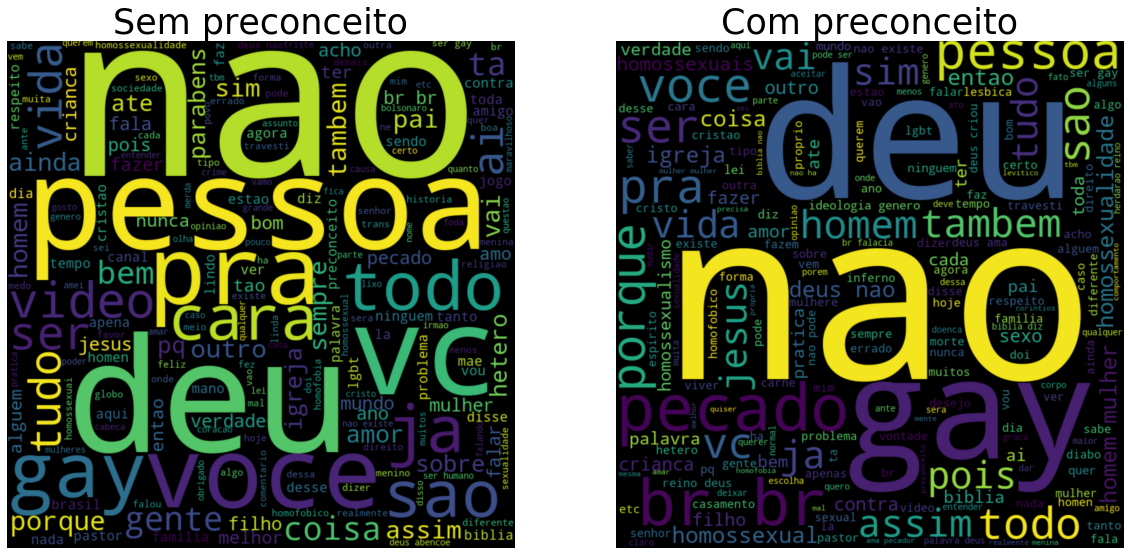

In [10]:
#Cria um novo campo transformando as listas em texto corrido
df_3['comentario_trat_2'] = df_3.comentario_trat.apply(lambda e: ' '.join(e))

#Junta todos os textos em uma única variável para fazer o wordCloud
texto_classe_0 = " ".join(review for review in df_3.comentario_trat_2[(df_3.target == 0)])
texto_classe_1 = " ".join(review for review in df_3.comentario_trat_2[(df_3.target == 1)])

# Gera a imagem do WordCloud
wordcloud_0 = WordCloud(width=800, height=800).generate(texto_classe_0)
wordcloud_1 = WordCloud(width=800, height=800).generate(texto_classe_1)

#Exibe imagens
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Sem preconceito', fontsize = 35)
ax1.imshow(wordcloud_0, interpolation='gaussian')
ax1.axis("off")

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Com preconceito', fontsize = 35)
ax2.imshow(wordcloud_1, interpolation='gaussian')
ax2.axis("off")

fig.show()

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


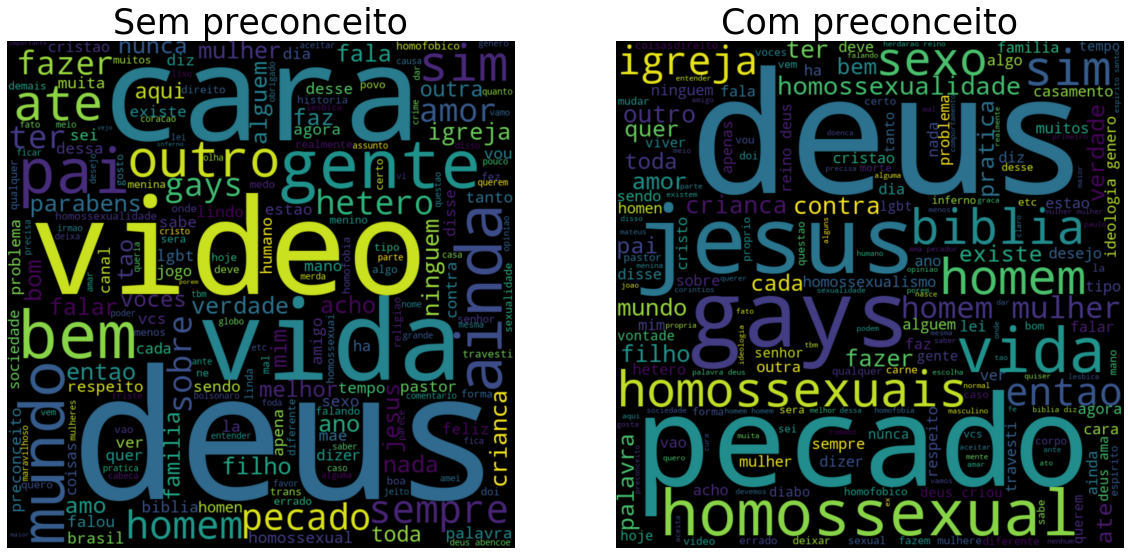

In [11]:
#Refaz o WordCloud com as palavras que aparecem muito nos dois anteriores

#Seleção de palavras pra desconsiderar
palavras_tirar = ['gay', 'br', 'nao', 'pessoa', 'pessoas', 'vc', 'voce', 'para', 'ser', 'deu', 'sao', 'vai', 'tambem', 'tb', 'todo', 'td', 'porque', 'pq', 'ja', 'assim', 'pra', 'tudo', 'todos', 'ta', 'ai',
                  'pois', 'pode', 'coisa']

#Subistitui na base da clase 0
texto_classe_0x = [word for word in texto_classe_0.split() if word not in palavras_tirar]
texto_classe_0x = ' '.join(texto_classe_0x)

#Subistitui na base da clase 1
texto_classe_1x = [word for word in texto_classe_1.split() if word not in palavras_tirar]
texto_classe_1x = ' '.join(texto_classe_1x)

# Gera as imagems novas do WordCloud
wordcloud_0x = WordCloud(width=800, height=800).generate(texto_classe_0x)
wordcloud_1x = WordCloud(width=800, height=800).generate(texto_classe_1x)

#Imprime as imagens
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Sem preconceito', fontsize = 35)
ax1.imshow(wordcloud_0x, interpolation='gaussian')
ax1.axis("off")
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Com preconceito', fontsize = 35)
ax2.imshow(wordcloud_1x, interpolation='gaussian')
ax2.axis("off")
fig.show()

<a id = "Analise_exploratoria_quantitativos"></a>

### 3.2 Monta Gráficos Quantitavos

In [12]:
#Cria nova coluna com a target em forma de texto
df_3['target_x'] = df_3.target.apply(lambda e: 'Sem preconceito' if e == 0 else 'Com preconceito')

#Cria uma nova coluna para valores muito grandes de tamanho dos comentários
df_3['qtde_caract_x'] = df_3.qtde_caract.apply(lambda e: 1000 if e >= 1000 else e)

,comentario
target_x,
Com preconceito,1664
Sem preconceito,12470


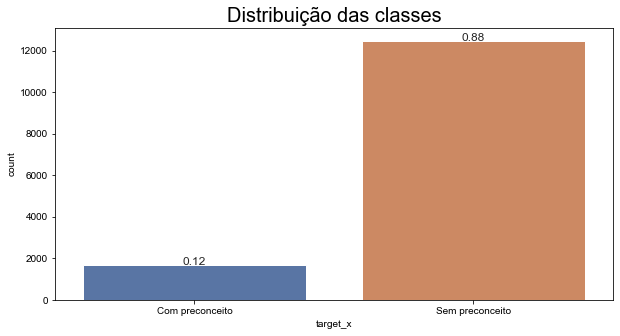

In [13]:
#Distribuição de classes
valor = df_3[['comentario', 'target_x']].groupby(by = ['target_x']).count()
display(valor)

total = float(len(df_3))

plt.figure(figsize=(10,5))
plt.title("Distribuição das classes", fontsize=20)
sns.set(style="white")
ax = sns.countplot(x = "target_x", data = df_3)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.2}'.format(height/total),
            ha="center") 
plt.show()

,target_x,qtde_likes_com_0,qtde_likes_sem_0
0,Com preconceito,1.905048,5.222405
1,Sem preconceito,3.786688,10.512021


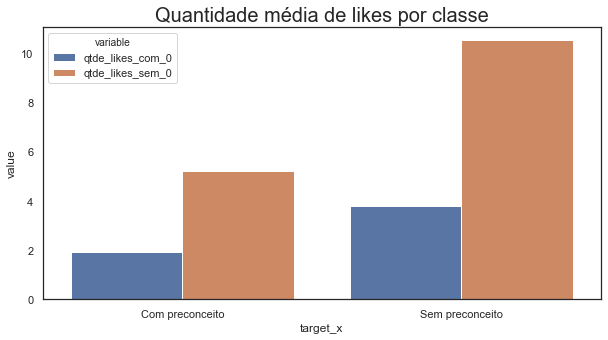

In [14]:
#Média de likes por classe, considerando comentários sem likes
likes_1 = df_3[(df_3.qtde_likes >= 0)][['target_x', 'qtde_likes']].groupby(by = ['target_x']).mean().rename(columns = {'qtde_likes': 'qtde_likes_com_0'})

#Média de likes por classe, desconsiderando comentários sem likes
likes_2 = df_3[(df_3.qtde_likes >= 1)][['target_x', 'qtde_likes']].groupby(by = ['target_x']).mean().rename(columns = {'qtde_likes': 'qtde_likes_sem_0'})

#Junta as duas tabelas
likes_3 = likes_1.merge(likes_2, how = "inner", on = 'target_x')
display(likes_3.reset_index())

#Redefine index
likes_3['target_x'] = likes_3.index

#Transforma a coluna em linha
likes_3 = pd.melt(likes_3, id_vars = 'target_x', value_vars=['qtde_likes_com_0', 'qtde_likes_sem_0'])

#Monta o gráfico
plt.figure(figsize=(10,5))
plt.title("Quantidade média de likes por classe", fontsize=20)
g = sns.barplot(x = 'target_x', y = 'value', hue = 'variable', data = likes_3)

hora_comentario,target_x,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,Com preconceito,99,91,80,80,61,44,38,26,20,23,24,47,52,76,89,91,89,98,96,91,102,66,102,79
1,Sem preconceito,732,718,769,656,492,401,275,182,146,163,205,320,411,474,558,643,670,675,639,661,616,668,653,743


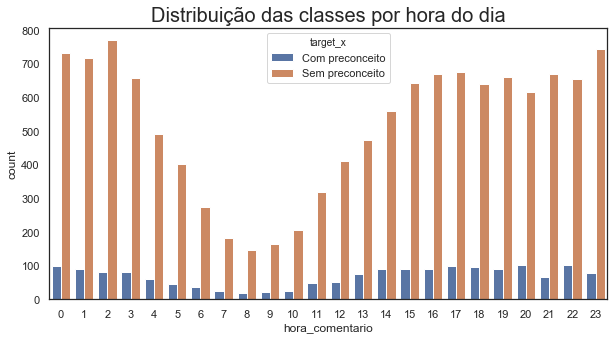

In [15]:
#Distribuição por hora do dia
valor = df_3[['hora_comentario', 'target_x', 'comentario']].groupby(by = ['hora_comentario', 'target_x']).count().reset_index()
valor = valor.pivot(index = 'target_x', columns ='hora_comentario', values = 'comentario').reset_index()
display(valor)

plt.figure(figsize=(10,5))
plt.title("Distribuição das classes por hora do dia", fontsize=20)
sns.set(style="white")
ax = sns.countplot(x = "hora_comentario", hue = 'target_x', data = df_3)

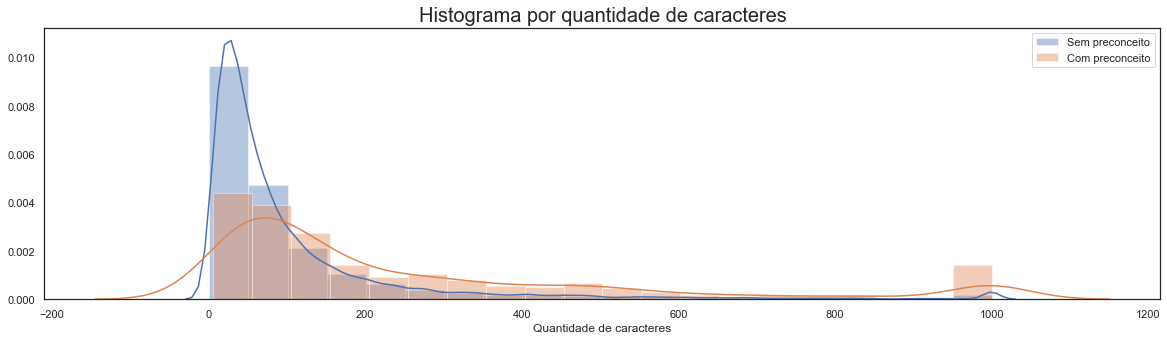

In [16]:
#Distribuição pela quantidade de caractéres dos comentários
plt.figure(figsize=(20,5))
plt.title("Histograma por quantidade de caracteres", fontsize=20)
sns.distplot(a = df_3[(df_3['target'] == 0)]['qtde_caract_x'], bins = 20, label = 'Sem preconceito')
sns.distplot(a = df_3[(df_3['target'] == 1)]['qtde_caract_x'], bins = 20, label = 'Com preconceito')
plt.legend(loc='upper right')
plt.xlabel('Quantidade de caracteres') 
plt.show()

,comentario
ano_comentario,
2009,2
2010,21
2011,50
2012,29
2013,128
2014,56
2015,111
2016,201
2017,599


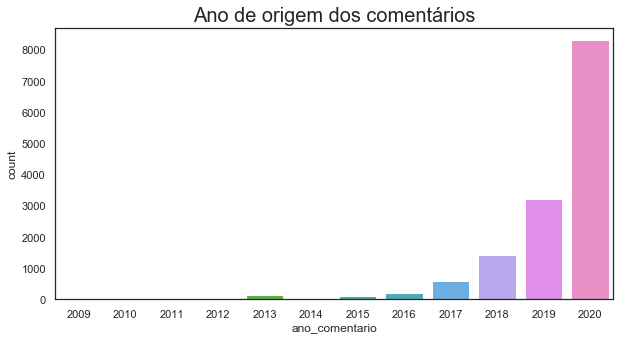

In [17]:
#Em que data se concentram os comentários
valor = df_3[['ano_comentario', 'comentario']].groupby(by = ['ano_comentario']).count()
display(valor)

plt.figure(figsize=(10,5))
plt.title("Ano de origem dos comentários", fontsize=20)
sns.set(style="white")
ax = sns.countplot(x = "ano_comentario", data = df_3[(df_3['ano_comentario'] > 0)])

<a id = "Modelagem"></a>

# 4. Modelagem

<a id = "Modelagem_count"></a>

### 4.1 Usa técnica do CountVectorizer

In [18]:
#Copia a base só com os campos que vou utilizar
df_modelagem_1 = df_3[['comentario_stemming', 'target']]
df_modelagem_1['comentario_stemming_2'] = df_3.comentario_stemming.apply(lambda e: ' '.join(e))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
# Separa em variáveis e resposta
df_modelagem_1_X = df_modelagem_1['comentario_stemming_2']
df_modelagem_1_y = df_modelagem_1['target']

#Separa do DF em treino e teste
df_modelagem_X_treino, df_modelagem_X_teste, df_modelagem_y_treino, df_modelagem_y_teste = train_test_split(df_modelagem_1_X, df_modelagem_1_y, test_size = 0.25, random_state = 42) 

#Fita o contador
cv = CountVectorizer()
cv.fit(df_modelagem_X_treino)

#Aplica o fit no treino
df_modelagem_X_treino_count = pd.DataFrame(cv.transform(df_modelagem_X_treino).todense(),columns=cv.get_feature_names())

#Seleciona palavras que ocorreram pelo menos 5 vezes (para ficarem menos palavras para acelerar o treinamento dos modelos)
lista = df_modelagem_X_treino_count.sum()
lista = pd.DataFrame({'palavra':lista.index, 'frequencia':lista.values})
lista = lista[(lista.frequencia >= 5 )]
lista = lista['palavra'].tolist()
df_modelagem_X_treino_count = df_modelagem_X_treino_count[lista]

#Aplica o fit no teste e deixa somente as colunas que quero
df_modelagem_X_teste_count = pd.DataFrame(cv.transform(df_modelagem_X_teste).todense(),columns=cv.get_feature_names())
df_modelagem_X_teste_count = df_modelagem_X_teste_count[lista]

<a id = "Modelagem_count_rl"></a>

### 4.1.1 Treina Regressão Logística

In [ ]:
#Define algoritmo
LR = LogisticRegression(random_state = 42)

#Parâmetros para o GridSearch
grid_param = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 0.3, 0.5, 1, 5, 10, 15, 20, 25, 30, 50],
              'class_weight': [{1: w} for w in [1, 3, 5, 7, 10, 13, 15, 20, 25, 30]]
             }

#Define modelo com o GridSearch
lr = GridSearchCV(estimator = LR,
                  param_grid = grid_param,
                  scoring = 'f1',
                  cv = 3,
                  n_jobs = -1,
                  verbose = 5)

#Treina Modelo
lr.fit(df_modelagem_X_treino_count, df_modelagem_y_treino)

In [85]:
filename = '..\models\CountVectorizer_linear_regression.sav'

#Salva o modelo
#pickle.dump(lr, open(filename, 'wb'))

#Carrega o modelo
lr = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\CountVectorizer_linear_regression.sav'>


In [86]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = lr.predict(df_modelagem_X_treino_count))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = lr.predict(df_modelagem_X_treino_count))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = lr.predict(df_modelagem_X_treino_count))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = lr.predict(df_modelagem_X_treino_count))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = lr.predict(df_modelagem_X_teste_count))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = lr.predict(df_modelagem_X_teste_count))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = lr.predict(df_modelagem_X_teste_count))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = lr.predict(df_modelagem_X_teste_count))

#Cria tabela com resultados
df_scores_lr = pd.DataFrame({'Algoritmo': ['Regressão Logística', 'Regressão Logística'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Bag of Words', 'Bag of Words'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_lr.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Regressão Logística,Treino,Bag of Words,0.879906,0.492593,0.747791,0.593939
1,Regressão Logística,Teste,Bag of Words,0.865025,0.451667,0.646778,0.531894


In [ ]:
#Feature Importance - Vê quais são as palavras mais importantes
important_features = pd.Series(data = lr.best_estimator_.coef_[0].tolist(), index = df_modelagem_X_treino_count.columns)
important_features.sort_values(ascending = False, inplace = True)
important_features.head(10)

In [ ]:
#Melhores parâmetros
lr.best_params_

<a id = "Modelagem_count_dt"></a>

### 4.1.2 Treina Árvore de Decisão

In [ ]:
#Define algoritmo
DT = DecisionTreeClassifier(random_state = 42)

#Parâmetros para o GridSearch
grid_param = {'criterion': ['gini'],
              'max_depth': [5, 10, 15, 20, 30, 40, 50],
              'max_features': [20, 50, 80, 110, 140, 170, 210, 250],
              'class_weight': [{1: w} for w in [1, 5, 10, 15, 25, 30]]
             }

#Define modelo com o GridSearch
dt = GridSearchCV(estimator = DT,
                  param_grid = grid_param,
                  scoring = 'f1',
                  cv = 3,
                  n_jobs = -1,
                  verbose = 5)

#Treina Modelo
dt.fit(df_modelagem_X_treino_count, df_modelagem_y_treino)

In [87]:
filename = '..\models\CountVectorizer_decision_tree.sav'

#Salva o modelo
#pickle.dump(dt, open(filename, 'wb'))

#Carrega o modelo
dt = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\CountVectorizer_decision_tree.sav'>


In [88]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = dt.predict(df_modelagem_X_treino_count))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = dt.predict(df_modelagem_X_treino_count))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = dt.predict(df_modelagem_X_treino_count))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = dt.predict(df_modelagem_X_treino_count))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = dt.predict(df_modelagem_X_teste_count))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = dt.predict(df_modelagem_X_teste_count))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = dt.predict(df_modelagem_X_teste_count))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = dt.predict(df_modelagem_X_teste_count))

#Cria tabela com resultados
df_scores_dt = pd.DataFrame({'Algoritmo': ['Árvore de Decisão', 'Árvore de Decisão'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Bag of Words', 'Bag of Words'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_dt.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Árvore de Decisão,Treino,Bag of Words,0.876321,0.480769,0.662651,0.557244
1,Árvore de Decisão,Teste,Bag of Words,0.832484,0.356073,0.510740,0.419608


In [ ]:
#Feature Importance - Vê quais são as palavras mais importantes
important_features = pd.Series(data = dt.best_estimator_.feature_importances_, index = df_modelagem_X_treino_count.columns)
important_features.sort_values(ascending = False, inplace = True)
important_features.head(10)

In [ ]:
#Melhores parâmetros
dt.best_params_

<a id = "Modelagem_count_rf"></a>

### 4.1.3 Treina Random Forest

In [ ]:
#Define algoritmo
RF = RandomForestClassifier(random_state = 42)

#Parâmetros para o GridSearch
grid_param = {'n_estimators': [100, 150, 200, 250],
              'criterion': ['gini'],
              'max_depth': [5, 10, 15, 20],
              'max_features': [40, 80, 120],
              'class_weight': [{1: w} for w in [1, 10, 20, 30]]
             }

#Define modelo com o GridSearch
rf = GridSearchCV(estimator = RF,
                  param_grid = grid_param,
                  scoring = 'f1',
                  cv = 3,
                  n_jobs = -1,
                  verbose = 5)

#Treina Modelo
rf.fit(df_modelagem_X_treino_count, df_modelagem_y_treino)

In [89]:
filename = '..\models\CountVectorizer_random_forest.sav'

#Salva o modelo
#pickle.dump(rf, open(filename, 'wb'))

#Carrega o modelo
rf = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\CountVectorizer_random_forest.sav'>


In [90]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = rf.predict(df_modelagem_X_treino_count))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = rf.predict(df_modelagem_X_treino_count))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = rf.predict(df_modelagem_X_treino_count))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = rf.predict(df_modelagem_X_treino_count))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = rf.predict(df_modelagem_X_teste_count))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = rf.predict(df_modelagem_X_teste_count))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = rf.predict(df_modelagem_X_teste_count))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = rf.predict(df_modelagem_X_teste_count))

#Cria tabela com resultados
df_scores_rf = pd.DataFrame({'Algoritmo': ['Random Forest', 'Random Forest'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Bag of Words', 'Bag of Words'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_rf.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Random Forest,Treino,Bag of Words,0.912547,0.589426,0.841767,0.693351
1,Random Forest,Teste,Bag of Words,0.843520,0.397554,0.620525,0.484623


In [ ]:
#Feature Importance - Vê quais são as palavras mais importantes
important_features = pd.Series(data = rf.best_estimator_.feature_importances_, index = df_modelagem_X_treino_count.columns)
important_features.sort_values(ascending = False, inplace = True)
important_features.head(10)

In [ ]:
#Melhores parâmetros
rf.best_params_

<a id = "Modelagem_count_et"></a>

### 4.1.4 Treina ExtraTrees

In [ ]:
#Define algoritmo
ET = ExtraTreesClassifier(random_state = 42)

#Parâmetros para o GridSearch
grid_param = {'n_estimators': [100, 150, 200, 250],
              'criterion': ['gini'],
              'max_depth': [5, 10, 15, 20],
              'max_features': [40, 80, 120],
              'class_weight': [{1: w} for w in [1, 10, 20, 30]]
             }

#Define modelo com o GridSearch
et = GridSearchCV(estimator = ET,
                  param_grid = grid_param,
                  scoring = 'f1',
                  cv = 3,
                  n_jobs = -1,
                  verbose = 5)

#Treina Modelo
et.fit(df_modelagem_X_treino_count, df_modelagem_y_treino)

In [91]:
filename = '..\models\CountVectorizer_extra_trees.sav'

#Salva o modelo
#pickle.dump(et, open(filename, 'wb'))

#Carrega o modelo
et = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\CountVectorizer_extra_trees.sav'>


In [92]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = et.predict(df_modelagem_X_treino_count))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = et.predict(df_modelagem_X_treino_count))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = et.predict(df_modelagem_X_treino_count))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = et.predict(df_modelagem_X_treino_count))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = et.predict(df_modelagem_X_teste_count))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = et.predict(df_modelagem_X_teste_count))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = et.predict(df_modelagem_X_teste_count))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = et.predict(df_modelagem_X_teste_count))

#Cria tabela com resultados
df_scores_et = pd.DataFrame({'Algoritmo': ['Extra Trees', 'Extra Trees'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Bag of Words', 'Bag of Words'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_et.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Extra Trees,Treino,Bag of Words,0.893302,0.527590,0.875502,0.658411
1,Extra Trees,Teste,Bag of Words,0.804188,0.349504,0.756563,0.478130


In [ ]:
#Feature Importance - Vê quais são as palavras mais importantes
important_features = pd.Series(data = et.best_estimator_.feature_importances_, index = df_modelagem_X_treino_count.columns)
important_features.sort_values(ascending = False, inplace = True)
important_features.head(10)

In [ ]:
#Melhores parâmetros
et.best_params_

<a id = "Modelagem_count_nb"></a>

### 4.1.5 Treina NaiveBayes

In [ ]:
#Define algoritmo
NB = MultinomialNB()

#Parâmetros para o GridSearch
grid_param = {'alpha': [0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 2]
             }

#Define modelo com o GridSearch
nb = GridSearchCV(estimator = NB,
                  param_grid = grid_param,
                  scoring = 'f1',
                  cv = 3,
                  n_jobs = -1,
                  verbose = 5)

#Treina Modelo
nb.fit(df_modelagem_X_treino_count, df_modelagem_y_treino)

In [93]:
filename = '..\models\CountVectorizer_naive_bayes.sav'

#Salva o modelo
#pickle.dump(nb, open(filename, 'wb'))

#Carrega o modelo
nb = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\CountVectorizer_naive_bayes.sav'>


In [94]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = nb.predict(df_modelagem_X_treino_count))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = nb.predict(df_modelagem_X_treino_count))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = nb.predict(df_modelagem_X_treino_count))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = nb.predict(df_modelagem_X_treino_count))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = nb.predict(df_modelagem_X_teste_count))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = nb.predict(df_modelagem_X_teste_count))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = nb.predict(df_modelagem_X_teste_count))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = nb.predict(df_modelagem_X_teste_count))

#Cria tabela com resultados
df_scores_nb = pd.DataFrame({'Algoritmo': ['Naive Bayes', 'Naive Bayes'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Bag of Words', 'Bag of Words'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_nb.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Naive Bayes,Treino,Bag of Words,0.897547,0.582555,0.450602,0.508152
1,Naive Bayes,Teste,Bag of Words,0.892756,0.570423,0.386635,0.460882


In [ ]:
#Feature Importance - Vê quais são as palavras mais importantes
important_features = pd.Series(data = nb.best_estimator_.feature_log_prob_[1].tolist(), index = df_modelagem_X_treino_count.columns)
important_features.sort_values(ascending = False, inplace = True)
important_features.head(10)

In [ ]:
#Melhores parâmetros
nb.best_params_

<a id = "Modelagem_count_lgbm"></a>

### 4.1.6 Treina LightGBM

In [ ]:
#Define algoritmo
LGBM = lgbm.LGBMClassifier()

#Faz tratamento no nome das colunas
df_modelagem_X_treino_count_lgbm = df_modelagem_X_treino_count.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#Parâmetros para o GridSearch
grid_param = {'bagging_fraction': [0.7],
              'min_gain_to_split': [0.05, 0.1],
              'max_depth': [5, 10, 15, 20, 30, 40, 50],
              'feature_fraction_bynode': [0.2, 0.4],
              'class_weight': [{1: w} for w in [1, 10, 20, 30]],
              'learning_rate': [0.1]
             }

#Define modelo com o GridSearch
lgbmx = GridSearchCV(estimator = LGBM,
                     param_grid = grid_param,
                     scoring = 'f1',
                     cv = 3,
                     n_jobs = -1,
                     verbose = 5)

#Treina Modelo
lgbmx.fit(df_modelagem_X_treino_count_lgbm, df_modelagem_y_treino)

In [95]:
filename = '..\models\CountVectorizer_lgbm.sav'

#Salva o modelo
#pickle.dump(lgbmx, open(filename, 'wb'))

#Carrega o modelo
lgbmx = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\CountVectorizer_lgbm.sav'>


In [96]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = lgbmx.predict(df_modelagem_X_treino_count))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = lgbmx.predict(df_modelagem_X_treino_count))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = lgbmx.predict(df_modelagem_X_treino_count))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = lgbmx.predict(df_modelagem_X_treino_count))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = lgbmx.predict(df_modelagem_X_teste_count))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = lgbmx.predict(df_modelagem_X_teste_count))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = lgbmx.predict(df_modelagem_X_teste_count))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = lgbmx.predict(df_modelagem_X_teste_count))

#Cria tabela com resultados
df_scores_lgbm = pd.DataFrame({'Algoritmo': ['Light GBM', 'Light GBM'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Bag of Words', 'Bag of Words'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_lgbm.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Light GBM,Treino,Bag of Words,0.869906,0.472245,0.915663,0.623121
1,Light GBM,Teste,Bag of Words,0.820600,0.370948,0.737470,0.493610


In [ ]:
#Feature Importance - Vê quais são as palavras mais importantes
important_features = pd.Series(data = lgbmx.best_estimator_.feature_importances_, index = df_modelagem_X_treino_count.columns)
important_features.sort_values(ascending = False, inplace = True)
important_features.head(10)

In [ ]:
#Melhores parâmetros
lgbmx.best_params_

<a id = "Modelagem_embedding"></a>

### 4.2 Usa técnica do Embedding

In [45]:
#Cria base com o Embedding
X_embedding = df_modelagem_1_X
tok = Tokenizer(num_words=10000)
tok.fit_on_texts(X_embedding)
sequences = tok.texts_to_sequences(X_embedding)
X_embedding_1 = sequence.pad_sequences(sequences, maxlen=150)
X_embedding_1 = pd.DataFrame(data = X_embedding_1)

#Separa do DF em treino e teste
df_modelagem_X_treino_embedding, df_modelagem_X_teste_embedding, df_modelagem_y_treino, df_modelagem_y_teste = train_test_split(X_embedding_1, df_modelagem_1_y, test_size = 0.25, random_state = 42) 

<a id = "Embedding_rl"></a>

### 4.2.1 Treina Regressão Logística

In [47]:
#Define algoritmo
LR_embedding = LogisticRegression(random_state = 42)

#Parâmetros para o GridSearch
grid_param = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 0.3, 0.5, 1, 5, 10, 15, 20, 25, 30, 50],
              'class_weight': [{1: w} for w in [1, 3, 5, 7, 10, 13, 15, 20, 25, 30]]
             }

#Define modelo com o GridSearch
lr_embedding = GridSearchCV(estimator = LR_embedding,
                            param_grid = grid_param,
                            scoring = 'f1',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 5)

#Treina Modelo
lr_embedding.fit(df_modelagem_X_treino_embedding, df_modelagem_y_treino)

Fitting 3 folds for each of 260 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed: 25.3min finished
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.3, 0.5, 1, 5, 10, 15, 20, 25,
                               30, 50],
                         'class_weight': [{1: 1}, {1: 3}, {1: 5}, {1: 7},
                                          {1: 10}, {1: 13}, {1: 15}, {1: 20},
                                          {1: 25}, {1: 30}],
             

In [49]:
filename = '..\models\Embedding_linear_regression.sav'

#Salva o modelo
#pickle.dump(lr_embedding, open(filename, 'wb'))

#Carrega o modelo
lr_embedding = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\Embedding_linear_regression.sav'>


In [50]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = lr_embedding.predict(df_modelagem_X_treino_embedding))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = lr_embedding.predict(df_modelagem_X_treino_embedding))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = lr_embedding.predict(df_modelagem_X_treino_embedding))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = lr_embedding.predict(df_modelagem_X_treino_embedding))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = lr_embedding.predict(df_modelagem_X_teste_embedding))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = lr_embedding.predict(df_modelagem_X_teste_embedding))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = lr_embedding.predict(df_modelagem_X_teste_embedding))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = lr_embedding.predict(df_modelagem_X_teste_embedding))

#Cria tabela com resultados
df_scores_lr_embedding = pd.DataFrame({'Algoritmo': ['Regressão Logística', 'Regressão Logística'],
                                       'Conjunto': ['Treino', 'Teste'],
                                       'Método': ['Embedding', 'Embedding'],
                                       'Accuracy': [accuracy_treino, accuracy_teste],
                                       'Precision': [precision_treino, precision_teste],
                                       'Recall': [recall_treino, recall_teste],
                                       'F1': [f1_treino, f1_teste]})
df_scores_lr_embedding.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Regressão Logística,Treino,Embedding,0.767170,0.245102,0.472289,0.322722
1,Regressão Logística,Teste,Embedding,0.784946,0.269283,0.474940,0.343696


<a id = "Embedding_dt"></a>

### 4.2.2 Treina Árvore de Decisão

In [55]:
#Define algoritmo
DT_embedding = DecisionTreeClassifier(random_state = 42)

#Parâmetros para o GridSearch
grid_param = {'criterion': ['gini'],
              'max_depth': [3, 5, 8, 10, 13, 15, 20],
              'max_features': [10, 20, 30, 40],
              'class_weight': [{1: w} for w in [1, 5, 10, 15, 25, 30]]
             }

#Define modelo com o GridSearch
dt_embedding = GridSearchCV(estimator = DT_embedding,
                  param_grid = grid_param,
                  scoring = 'f1',
                  cv = 3,
                  n_jobs = -1,
                  verbose = 5)

#Treina Modelo
dt_embedding.fit(df_modelagem_X_treino_embedding, df_modelagem_y_treino)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   11.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': [{1: 1}, {1: 5}, {1: 10}, {1: 15},
                                          {1: 25}, {1: 30}],
   

In [57]:
filename = '..\models\Embedding_decision_tree.sav'

#Salva o modelo
#pickle.dump(dt_embedding, open(filename, 'wb'))

#Carrega o modelo
dt_embedding = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\Embedding_decision_tree.sav'>


In [59]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = dt_embedding.predict(df_modelagem_X_treino_embedding))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = dt_embedding.predict(df_modelagem_X_treino_embedding))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = dt_embedding.predict(df_modelagem_X_treino_embedding))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = dt_embedding.predict(df_modelagem_X_treino_embedding))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = dt_embedding.predict(df_modelagem_X_teste_embedding))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = dt_embedding.predict(df_modelagem_X_teste_embedding))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = dt_embedding.predict(df_modelagem_X_teste_embedding))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = dt_embedding.predict(df_modelagem_X_teste_embedding))

#Cria tabela com resultados
df_scores_dt_embedding = pd.DataFrame({'Algoritmo': ['Árvore de Decisão', 'Árvore de Decisão'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Embedding', 'Embedding'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_dt_embedding.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Árvore de Decisão,Treino,Embedding,0.817736,0.342214,0.598394,0.435418
1,Árvore de Decisão,Teste,Embedding,0.794567,0.282270,0.474940,0.354093


<a id = "Embedding_rf"></a>

### 4.2.3 Treina Random Forest

In [63]:
#Define algoritmo
RF_embedding = RandomForestClassifier(random_state = 42)

#Parâmetros para o GridSearch
grid_param = {'n_estimators': [150, 200, 250],
              'criterion': ['gini'],
              'max_depth': [5, 8, 10],
              'max_features': [10, 20, 30, 40],
              'class_weight': [{1: w} for w in [1, 5, 10, 15, 25, 30]]
             }

#Define modelo com o GridSearch
rf_embedding = GridSearchCV(estimator = RF_embedding,
                  param_grid = grid_param,
                  scoring = 'f1',
                  cv = 3,
                  n_jobs = -1,
                  verbose = 5)

#Treina Modelo
rf_embedding.fit(df_modelagem_X_treino_embedding, df_modelagem_y_treino)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 13.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'cl

In [65]:
filename = '..\models\Embedding_random_forest.sav'

#Salva o modelo
#pickle.dump(rf_embedding, open(filename, 'wb'))

#Carrega o modelo
rf_embedding = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\Embedding_random_forest.sav'>


In [66]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = rf_embedding.predict(df_modelagem_X_treino_embedding))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = rf_embedding.predict(df_modelagem_X_treino_embedding))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = rf_embedding.predict(df_modelagem_X_treino_embedding))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = rf_embedding.predict(df_modelagem_X_treino_embedding))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = rf_embedding.predict(df_modelagem_X_teste_embedding))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = rf_embedding.predict(df_modelagem_X_teste_embedding))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = rf_embedding.predict(df_modelagem_X_teste_embedding))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = rf_embedding.predict(df_modelagem_X_teste_embedding))

#Cria tabela com resultados
df_scores_rf_embedding = pd.DataFrame({'Algoritmo': ['Random Forest', 'Random Forest'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Embedding', 'Embedding'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_rf_embedding.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Random Forest,Treino,Embedding,0.848396,0.429462,0.885141,0.578326
1,Random Forest,Teste,Embedding,0.791737,0.291721,0.529833,0.376271


<a id = "Embedding_et"></a>

### 4.2.4 Treina ExtraTrees

In [67]:
#Define algoritmo
ET_embedding = ExtraTreesClassifier(random_state = 42)

#Parâmetros para o GridSearch
grid_param = {'n_estimators': [150, 200, 250],
              'criterion': ['gini'],
              'max_depth': [5, 8, 10],
              'max_features': [10, 20, 30, 40],
              'class_weight': [{1: w} for w in [1, 5, 10, 15, 25, 30]]
             }

#Define modelo com o GridSearch
et_embedding = GridSearchCV(estimator = ET_embedding,
                  param_grid = grid_param,
                  scoring = 'f1',
                  cv = 3,
                  n_jobs = -1,
                  verbose = 5)

#Treina Modelo
et_embedding.fit(df_modelagem_X_treino_embedding, df_modelagem_y_treino)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 23.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators='warn', n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': [{1: 1}, {

In [69]:
filename = '..\models\Embedding_extra_trees.sav'

#Salva o modelo
#pickle.dump(et_embedding, open(filename, 'wb'))

#Carrega o modelo
et_embedding = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\Embedding_extra_trees.sav'>


In [70]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = et_embedding.predict(df_modelagem_X_treino_embedding))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = et_embedding.predict(df_modelagem_X_treino_embedding))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = et_embedding.predict(df_modelagem_X_treino_embedding))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = et_embedding.predict(df_modelagem_X_treino_embedding))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = et_embedding.predict(df_modelagem_X_teste_embedding))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = et_embedding.predict(df_modelagem_X_teste_embedding))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = et_embedding.predict(df_modelagem_X_teste_embedding))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = et_embedding.predict(df_modelagem_X_teste_embedding))

#Cria tabela com resultados
df_scores_et_embedding = pd.DataFrame({'Algoritmo': ['Extra Trees', 'Extra Trees'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Embedding', 'Embedding'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_et_embedding.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Extra Trees,Treino,Embedding,0.857453,0.383128,0.350201,0.365925
1,Extra Trees,Teste,Embedding,0.851726,0.365039,0.338902,0.351485


<a id = "Embedding_nb"></a>

### 4.2.5 Treina NaiveBayes

In [71]:
#Define algoritmo
NB_embedding = MultinomialNB()

#Parâmetros para o GridSearch
grid_param = {'alpha': [0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 2]
             }

#Define modelo com o GridSearch
nb_embedding = GridSearchCV(estimator = NB_embedding,
                  param_grid = grid_param,
                  scoring = 'f1',
                  cv = 3,
                  n_jobs = -1,
                  verbose = 5)

#Treina Modelo
nb_embedding.fit(df_modelagem_X_treino_embedding, df_modelagem_y_treino)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.2s finished
alpha too small will result in numeric errors, setting alpha = 1.0e-10


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=5)

In [73]:
filename = '..\models\Embedding_naive_bayes.sav'

#Salva o modelo
#pickle.dump(nb_embedding, open(filename, 'wb'))

#Carrega o modelo
nb_embedding = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\Embedding_naive_bayes.sav'>


In [74]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = nb_embedding.predict(df_modelagem_X_treino_embedding))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = nb_embedding.predict(df_modelagem_X_treino_embedding))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = nb_embedding.predict(df_modelagem_X_treino_embedding))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = nb_embedding.predict(df_modelagem_X_treino_embedding))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = nb_embedding.predict(df_modelagem_X_teste_embedding))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = nb_embedding.predict(df_modelagem_X_teste_embedding))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = nb_embedding.predict(df_modelagem_X_teste_embedding))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = nb_embedding.predict(df_modelagem_X_teste_embedding))

#Cria tabela com resultados
df_scores_nb_embedding = pd.DataFrame({'Algoritmo': ['Naive Bayes', 'Naive Bayes'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Embedding', 'Embedding'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_nb_embedding.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Naive Bayes,Treino,Embedding,0.850849,0.324268,0.248996,0.281690
1,Naive Bayes,Teste,Embedding,0.867572,0.417508,0.295943,0.346369


<a id = "Embedding_lgbm"></a>

### 4.2.6 Treina LightGBM

In [76]:
#Define algoritmo
LGBM_embedding = lgbm.LGBMClassifier()

#Parâmetros para o GridSearch
grid_param = {'bagging_fraction': [0.7],
              'min_gain_to_split': [0.05, 0.1],
              'max_depth': [5, 8, 10],
              'feature_fraction_bynode': [0.2, 0.4],
              'class_weight': [{1: w} for w in [1, 10, 20, 30]],
              'learning_rate': [0.1]
             }

#Define modelo com o GridSearch
lgbmx_embedding = GridSearchCV(estimator = LGBM_embedding,
                     param_grid = grid_param,
                     scoring = 'f1',
                     cv = 3,
                     n_jobs = -1,
                     verbose = 5)

#Treina Modelo
lgbmx_embedding.fit(df_modelagem_X_treino_embedding, df_modelagem_y_treino)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambd...
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'bagging_fraction': [0.7],
                         'class_weight': [{1: 1}, 

In [78]:
filename = '..\models\Embedding_lgbm.sav'

#Salva o modelo
#pickle.dump(lgbmx_embedding, open(filename, 'wb'))

#Carrega o modelo
lgbmx_embedding = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
unclosed file <_io.BufferedReader name='..\\models\\Embedding_lgbm.sav'>


In [80]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = df_modelagem_y_treino, y_pred = lgbmx_embedding.predict(df_modelagem_X_treino_embedding))
precision_treino = precision_score(y_true = df_modelagem_y_treino, y_pred = lgbmx_embedding.predict(df_modelagem_X_treino_embedding))
recall_treino = recall_score(y_true = df_modelagem_y_treino, y_pred = lgbmx_embedding.predict(df_modelagem_X_treino_embedding))
f1_treino = f1_score(y_true = df_modelagem_y_treino, y_pred = lgbmx_embedding.predict(df_modelagem_X_treino_embedding))

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = df_modelagem_y_teste, y_pred = lgbmx_embedding.predict(df_modelagem_X_teste_embedding))
precision_teste = precision_score(y_true = df_modelagem_y_teste, y_pred = lgbmx_embedding.predict(df_modelagem_X_teste_embedding))
recall_teste = recall_score(y_true = df_modelagem_y_teste, y_pred = lgbmx_embedding.predict(df_modelagem_X_teste_embedding))
f1_teste = f1_score(y_true = df_modelagem_y_teste, y_pred = lgbmx_embedding.predict(df_modelagem_X_teste_embedding))

#Cria tabela com resultados
df_scores_lgbm_embedding = pd.DataFrame({'Algoritmo': ['Light GBM', 'Light GBM'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Embedding', 'Embedding'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_lgbm_embedding.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Light GBM,Treino,Embedding,0.745283,0.299752,0.874699,0.446494
1,Light GBM,Teste,Embedding,0.697227,0.225779,0.639618,0.333748


<a id = "Modelagem_count_rnn"></a>

### 4.2.7 Treina Rede Neural

In [81]:
#Split para Rede Neural
df_modelagem_X_treino_rn, df_modelagem_X_teste_rn, df_modelagem_y_treino_rn, df_modelagem_y_teste_rn = train_test_split(df_modelagem_1_X, df_modelagem_1_y, test_size = 0.25, random_state = 42) 


#Variáveis
max_features = 4000
max_words = max_features
max_len = 300

#Prepara conjunto de treinamento
X_train_dl = df_modelagem_X_treino_rn
y_train_dl = df_modelagem_y_treino_rn.values.reshape(-1, 1)
tok = Tokenizer(num_words=max_features)
tok.fit_on_texts(X_train_dl)
sequences = tok.texts_to_sequences(X_train_dl)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

#Prepara conjunto de teste
X_test_dl = df_modelagem_X_teste_rn
y_test_dl = df_modelagem_y_teste_rn.values.reshape(-1, 1)
test_sequences = tok.texts_to_sequences(X_test_dl)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [40]:
#Cria o modelo
def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 100, input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

rnn = RNN()
rnn.summary()
rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 300, 100)          400000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               117248    
_________________________________________________________________
FC1 (Dense)                  (None, 256)               33024     
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [ ]:
#Treina o modelo
rnn.fit(sequences_matrix, y_train_dl, batch_size=256, epochs=10,
        validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

In [82]:
filename = '..\models\CountVectorizer_rnn.sav'

#Salva o modelo
#pickle.dump(rnn, open(filename, 'wb'))

#Carrega o modelo
rnn = pickle.load(open(filename, 'rb'))

invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
invalid escape sequence \m
Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
unclosed file <_io.BufferedReader name='..\\models\\CountVectorizer_rnn.sav'>


In [83]:
#Scora no conjunto de treino
y_prob_dl_treino = rnn.predict(sequences_matrix)
y_pred_dl_treino = np.where(y_prob_dl_treino <= .5, 0, 1)

# #Scora no conjunto de teste
y_prob_dl_teste = rnn.predict(test_sequences_matrix)
y_pred_dl_teste = np.where(y_prob_dl_teste <= .5, 0, 1)

In [84]:
#Avalia o resultado no conjunto de Treino
accuracy_treino = accuracy_score(y_true = y_train_dl, y_pred = y_pred_dl_treino)
precision_treino = precision_score(y_true = y_train_dl, y_pred = y_pred_dl_treino)
recall_treino = recall_score(y_true = y_train_dl, y_pred = y_pred_dl_treino)
f1_treino = f1_score(y_true = y_train_dl, y_pred = y_pred_dl_treino)

#Avalia o resultado no conjunto de Teste
accuracy_teste = accuracy_score(y_true = y_test_dl, y_pred = y_pred_dl_teste)
precision_teste = precision_score(y_true = y_test_dl, y_pred = y_pred_dl_teste)
recall_teste = recall_score(y_true = y_test_dl, y_pred = y_pred_dl_teste)
f1_teste = f1_score(y_true = y_test_dl, y_pred = y_pred_dl_teste)

#Cria tabela com resultados
df_scores_rn_embedding = pd.DataFrame({'Algoritmo': ['Rede Neural', 'Rede Neural'],
                             'Conjunto': ['Treino', 'Teste'],
                             'Método': ['Embedding ', 'Embedding'],
                             'Accuracy': [accuracy_treino, accuracy_teste],
                             'Precision': [precision_treino, precision_teste],
                             'Recall': [recall_treino, recall_teste],
                             'F1': [f1_treino, f1_teste]})
df_scores_rn_embedding.head()

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Rede Neural,Treino,Embedding,0.922075,0.685892,0.620884,0.651771
1,Rede Neural,Teste,Embedding,0.889926,0.549020,0.400955,0.463448


<a id = "Modelagem_count_resultados"></a>

### 4.1.8 Junta todos os resultados

In [97]:
#Junta todos os dataframes de resultados
resultados_countvectorizer = pd.concat(objs = [df_scores_lr, df_scores_rf, df_scores_et, df_scores_nb, df_scores_dt, df_scores_lgbm, 
                                               df_scores_lr_embedding, df_scores_rf_embedding, df_scores_et_embedding, df_scores_nb_embedding, 
                                               df_scores_dt_embedding, df_scores_lgbm_embedding, df_scores_rn_embedding], axis = 0)

#Ordena
resultados_countvectorizer = resultados_countvectorizer.sort_values(by = ['Conjunto','Recall'], ascending = False).reset_index(drop = True)
display(resultados_countvectorizer)

,Algoritmo,Conjunto,Método,Accuracy,Precision,Recall,F1
0,Light GBM,Treino,Bag of Words,0.869906,0.472245,0.915663,0.623121
1,Random Forest,Treino,Embedding,0.848396,0.429462,0.885141,0.578326
2,Extra Trees,Treino,Bag of Words,0.893302,0.527590,0.875502,0.658411
3,Light GBM,Treino,Embedding,0.745283,0.299752,0.874699,0.446494
4,Random Forest,Treino,Bag of Words,0.912547,0.589426,0.841767,0.693351
5,Regressão Logística,Treino,Bag of Words,0.879906,0.492593,0.747791,0.593939
6,Árvore de Decisão,Treino,Bag of Words,0.876321,0.480769,0.662651,0.557244
7,Rede Neural,Treino,Embedding,0.922075,0.685892,0.620884,0.651771
8,Árvore de Decisão,Treino,Embedding,0.817736,0.342214,0.598394,0.435418
9,Regressão Logística,Treino,Embedding,0.767170,0.245102,0.472289,0.322722
